In [382]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
from multiprocess import Pool

0.043137254901960784


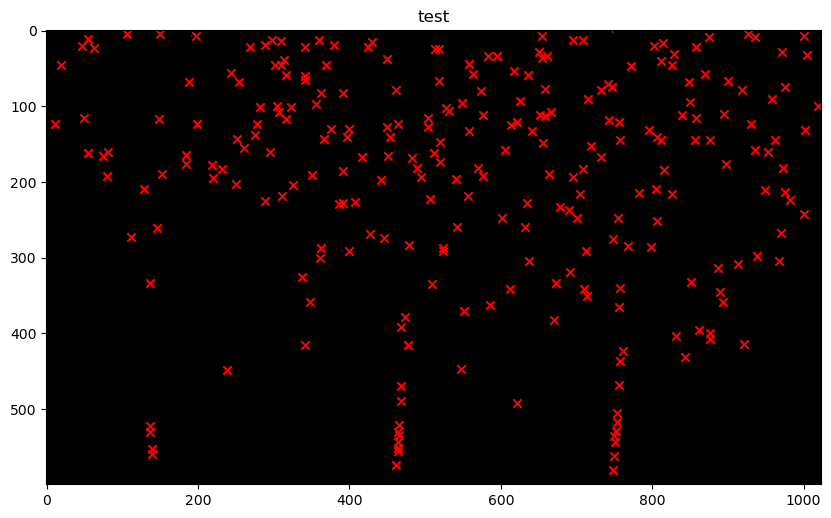

In [375]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/'

imagesDir = []
for imageDir in glob.glob(directory+'*.tif'):
    imagesDir.append(imageDir)
imagesDir = np.sort(imagesDir)

# TEST
testImg = rgb2gray(cv2.imread(imagesDir[0])[200:800,:])
print(np.max(testImg))
testImg /= np.max(testImg)
testImg = np.where(testImg>0.20,testImg,0)
plt.figure(figsize=(10,16))
plt.imshow(testImg,cmap='Greys_r')
# detect peaks
peaks = peak_local_max(testImg,min_distance=4)
for peak in peaks:
    plt.scatter(peak[1],peak[0],color='red',marker='x')
plt.title('test')
plt.show()

In [369]:
imagesDir[-1]

'/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/B00200.tif'

# Read all particles

In [376]:
pos_t = []
for imageDir in imagesDir[::]:
    image = rgb2gray(cv2.imread(imageDir)[200:800,:])
    image /= 0.03529411764705882
    image = np.where(image>0.20,image,0)
    peaks = peak_local_max(image,min_distance=4)
    pos_t.append(peaks)
    # print(imageDir)

## Print a few to check

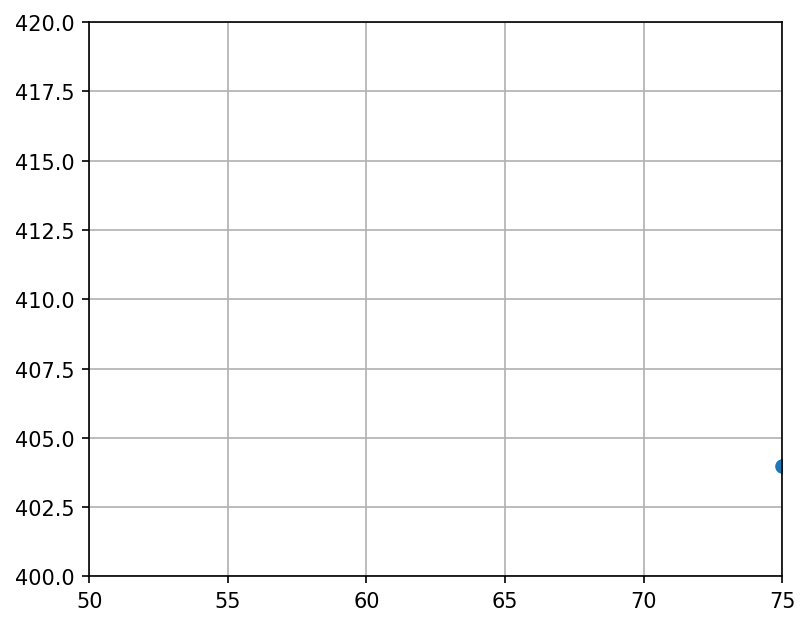

In [377]:
plt.figure(dpi=150)
myColors = np.tile(['tab:blue','tab:orange','purple','green','red'],10)
for ip,peaks in enumerate(pos_t[:30]):
    plt.scatter(peaks[:,1],peaks[:,0],color=myColors[ip])
plt.gca().invert_yaxis()
plt.grid()
plt.ylim(400,420)
plt.xlim(50,75)
plt.gca().set_aspect('equal')
plt.show()

# Find trajectories

In [378]:
class trajectory:
    def __init__(self, position):
        self.position = position
    def append(self,position):
        self.position = np.vstack((self.position,position))
    def lastPos(self):
        if self.position.shape==(2,):
            return self.position
        else:
            return self.position[-1]
        
def dist(a,b):
    return np.linalg.norm(a-b)
def vector(a,b):
    return [b[0]-a[0],b[1]-a[1]]

# create trajectory list
trajectories = []
# fill up list with first-frame particles (they're all new trajectories)
for _,particle in enumerate(pos_t[0]):
    trajectories.append(trajectory(particle))

def pool_handler():
    p = Pool(6)
    p.map(analysee, sphereDirs)


if __name__ == '__main__':
    pool_handler()

for time,frame in enumerate(pos_t[1:]): # loop over frames
    for i,particle in enumerate(frame): # loop over particles 
        matched = 0 # is that particle matched?
        for tr in trajectories: # loop over known trajectories
            
            # this snippet of code does the job for a non-predictor case
            # if dist(particle,tr.lastPos())<6:
            #     tr.append(particle)
            #     matched = 1

            if tr.position.shape==(2,): # if the trajectory is one point (no prediction possible)
                if dist(particle,tr.lastPos())<6: # within a sphere of radius r
                    tr.append(particle)
                    matched = 1 # found a particle
            else: # if the trajectory is more than one point, i can predict
                predicted = tr.position[-2] + vector(tr.position[-2],tr.position[-1])
                if dist(particle,predicted) < 5: # within a sphere of radius r
                    tr.append(particle)
                    matched = 1  # found a particle
        if matched==0: # if still not matched, it means it's a new track
            trajectories.append(trajectory(particle))
        # print(f'frame {i}')
    print(f'time {time}')

time 0
time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45
time 46
time 47
time 48
time 49


KeyboardInterrupt: 

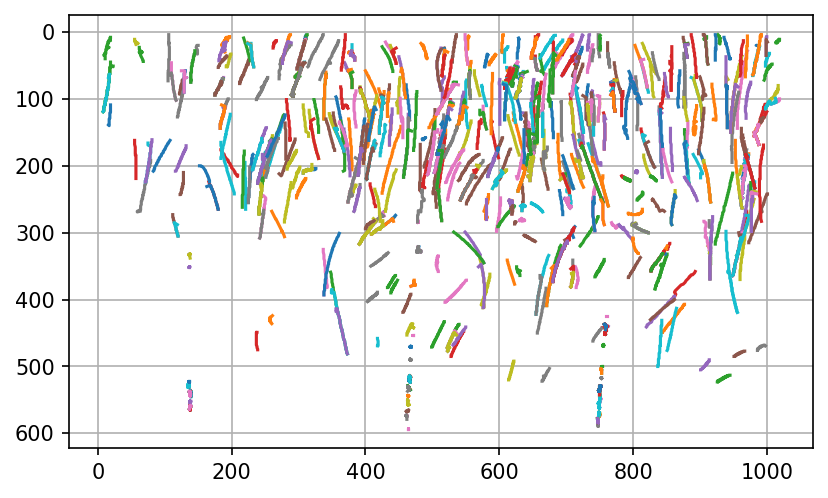

In [381]:
plt.figure(dpi=150)
for tr in trajectories:
    if tr.position.shape==(2,): continue
    if tr.position.shape[0]<30:continue
    # print(tr.position.shape)
    plt.plot(tr.position[:,1],tr.position[:,0])
plt.grid()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
# plt.ylim(400,420)
# plt.xlim(50,75)
plt.show()